In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print("Version de TensorFlow :", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))

Version de TensorFlow : 2.17.1
GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def load_image(file_path, target_size=(256, 256)):

    #Load and resize an image to the target size.

    image = Image.open(file_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image).astype('float32') / 127.5 - 1  # Normalize to [-1, 1]
    return image

In [6]:
def load_dataset(input_dir, target_dir, target_size=(256, 256)):

    #Load and resize datasets from input and target directories.

    input_images = sorted(glob.glob(f"{input_dir}/*.jpg"))
    target_images = sorted(glob.glob(f"{target_dir}/*.jpg"))

    input_data = [load_image(img, target_size) for img in input_images]
    target_data = [load_image(img, target_size) for img in target_images]

    min_size = min(len(input_data), len(target_data))
    return np.array(input_data[:min_size]), np.array(target_data[:min_size])


In [7]:
def load_and_align_datasets(input_dir, target_dir, target_size=(256, 256)):

    #Charge les images des répertoires spécifiés, les redimensionne et les aligne pour avoir le même nombre d'images.

    # Charger les chemins des fichiers
    input_images = sorted(glob.glob(os.path.join(input_dir, '*.jpg')))
    target_images = sorted(glob.glob(os.path.join(target_dir, '*.jpg')))

    # S'assurer que les deux ensembles ont le même nombre d'images
    min_size = min(len(input_images), len(target_images))
    input_images = input_images[:min_size]
    target_images = target_images[:min_size]

    # Charger et redimensionner les images
    input_data = [load_image(img, target_size) for img in input_images]
    target_data = [load_image(img, target_size) for img in target_images]

    return np.array(input_data), np.array(target_data)

In [8]:
def build_generator():
    inputs = Input(shape=[256, 256, 3])

    # Encoder
    down1 = Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = LeakyReLU(0.2)(down1)

    down2 = Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(0.2)(down2)

    down3 = Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(0.2)(down3)

    # Decoder
    up1 = Conv2DTranspose(128, 4, strides=2, padding='same')(down3)
    up1 = BatchNormalization()(up1)
    up1 = ReLU()(up1)
    up1 = Concatenate()([up1, down2])

    up2 = Conv2DTranspose(64, 4, strides=2, padding='same')(up1)
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2)
    up2 = Concatenate()([up2, down1])

    outputs = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up2)

    return Model(inputs, outputs)

In [9]:
# Discriminator Model
def build_discriminator():
    input_image = Input(shape=[256, 256, 3])
    target_image = Input(shape=[256, 256, 3])

    x = Concatenate()([input_image, target_image])
    #64
    x = Conv2D(64, 4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #128
    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    #256
    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    #512
    x = Conv2D(512, 4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # patch output
    x = Conv2D(1, 4, strides=1, padding='same', activation='sigmoid')(x)
    # define model
    return Model([input_image, target_image], x)

In [10]:
# Loss Functions
def adversarial_loss(disc_generated_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(disc_generated_output), disc_generated_output))

In [11]:
def l1_loss(gen_output, target):
    return tf.reduce_mean(tf.abs(target - gen_output))

In [12]:
def generator_loss(disc_generated_output, gen_output, target, lambda_l1=100):
    adv_loss = adversarial_loss(disc_generated_output)
    l1 = l1_loss(gen_output, target)
    return adv_loss + lambda_l1 * l1

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    return real_loss + fake_loss

In [14]:
@tf.function
def train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer, lambda_l1=100):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        # Discriminator outputs
        real_output = discriminator([input_image, target_image], training=True)
        fake_output = discriminator([input_image, gen_output], training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output, gen_output, target_image, lambda_l1)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients (ensure these optimizers are initialized outside the function)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [15]:
def train(dataset, generator, discriminator, gen_optimizer, disc_optimizer, epochs=10):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_gen_loss = []
        epoch_disc_loss = []

        for input_image, target_image in dataset:
            gen_loss, disc_loss = train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer)
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())

        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))


    # Vérification des données avant tracé
    if not gen_losses or not disc_losses:
        print("Erreur : Les pertes sont vides. Vérifiez les étapes de calcul.")
        return

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.title("Learning Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("learning_curves.png")  # Sauvegarde les courbes
    plt.show()


In [16]:
# Apply the model to new images
def cartoonify_image(generator, image_path, target_size=(256, 256)):
    input_image = load_image(image_path, target_size)
    generated_image = generator(input_image[tf.newaxis, ...], training=False)
    generated_image = ((generated_image.numpy().squeeze() + 1) / 2 * 255).astype('uint8')
    return Image.fromarray(generated_image)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


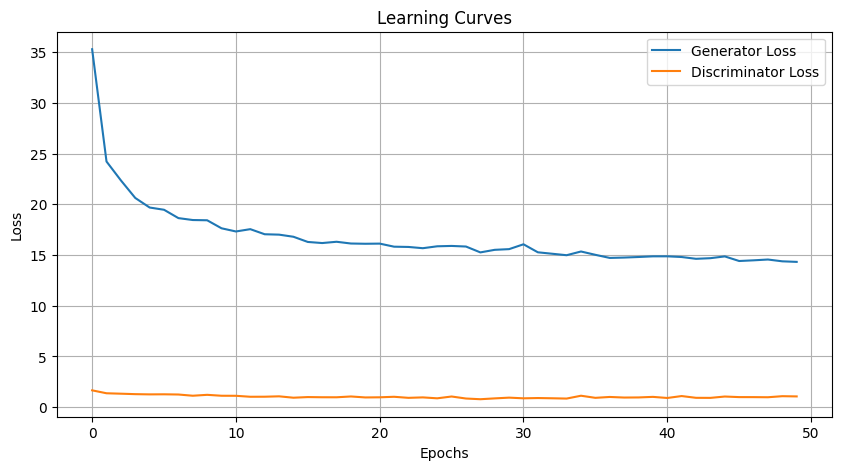

Evaluating on test dataset...


Training Complete!


In [17]:
from sklearn.model_selection import train_test_split

# Load the dataset
input_dir = "/content/drive/MyDrive/GAN/dataset/real_images"
target_dir = "/content/drive/MyDrive/GAN/dataset/cartoonized"

input_images, target_images = load_and_align_datasets(input_dir, target_dir, target_size=(256, 256))

# Split into train and test sets
input_train, input_test, target_train, target_test = train_test_split(
    input_images, target_images, test_size=0.2, random_state=42
)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(1000).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test)).batch(8)

# Build models
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)

# Train
train(train_dataset,
    generator,
    discriminator,
    gen_optimizer,
    disc_optimizer,
    epochs=50
)

# Evaluate on the test set (Optional)
print("Evaluating on test dataset...")
for input_image, target_image in test_dataset:
    generated_image = generator(input_image, training=False)

# Save the models
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

print("Training Complete!")

In [21]:
# Test on a new image
test_image_path = "/content/voiture.jpg"
result_image = cartoonify_image(generator, test_image_path)

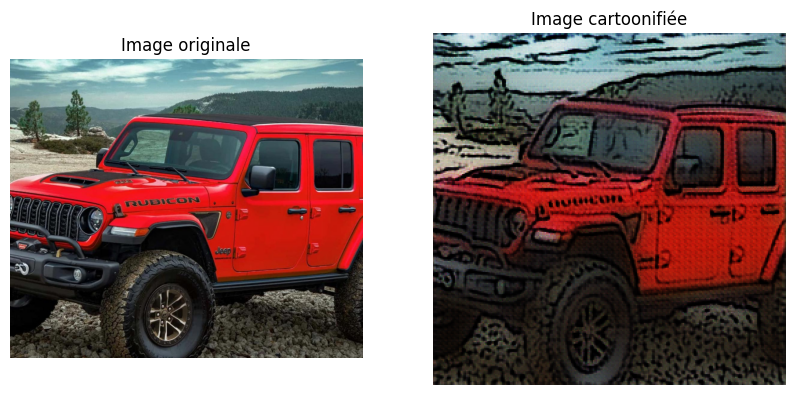

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lire les images
test_image = mpimg.imread(test_image_path)


# Afficher les images côte à côte
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image originale
axs[0].imshow(test_image)
axs[0].set_title("Image originale")
axs[0].axis('off')

# Image cartoonifiée
axs[1].imshow(result_image)
axs[1].set_title("Image cartoonifiée")
axs[1].axis('off')

# Afficher le graphique
plt.show()


In [18]:
# Test on a new image
test_image_path = "/content/rihanna.jpg"
result_image = cartoonify_image(generator, test_image_path)



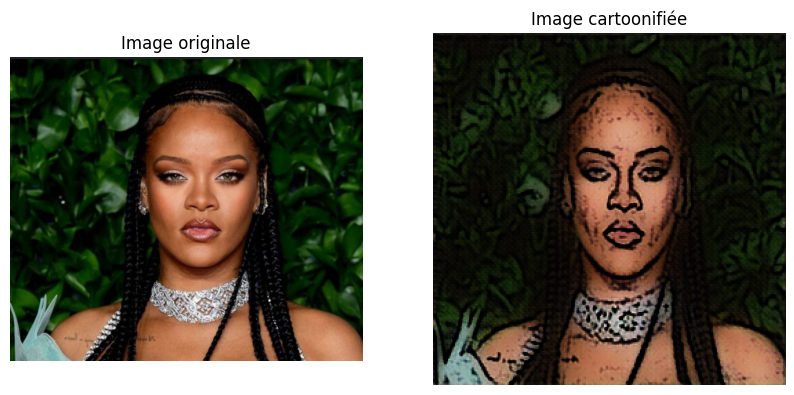

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lire les images
test_image = mpimg.imread(test_image_path)


# Afficher les images côte à côte
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image originale
axs[0].imshow(test_image)
axs[0].set_title("Image originale")
axs[0].axis('off')

# Image cartoonifiée
axs[1].imshow(result_image)
axs[1].set_title("Image cartoonifiée")
axs[1].axis('off')

# Afficher le graphique
plt.show()
